# Assignment 3: Multi-Class Image Classification with CNNs

*Author: Brian Sterle*

*Date: April 15th, 2025*
___
### Installation
Before running the notebook, setup the data:

```bash
# in root dir of project
./fetch-data.sh
```

This fetches data from Kaggle via `curl` and unzips it to the `data/` directory

In [75]:
# %% [code]
import os
import numpy as np
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Determine which device to use: cuda > mps > cpu
device = torch.device("cuda" if torch.cuda.is_available() 
                      else "mps" if torch.backends.mps.is_available() 
                      else "cpu")
print(f"Using device: {device}")

# Verify torch installation by creating a random tensor on the selected device
x = torch.rand(5, 3, device=device)
print("Random Tensor on selected device:\n", x)


Using device: cuda
Random Tensor on selected device:
 tensor([[0.8155, 0.8736, 0.6934],
        [0.5577, 0.4665, 0.6076],
        [0.1749, 0.1679, 0.9172],
        [0.5896, 0.3497, 0.3365],
        [0.6148, 0.1849, 0.2080]], device='cuda:0')


In [76]:
# Define directory paths for the dataset
data_dir = 'data'
train_dir = os.path.join(data_dir, 'seg_train', 'seg_train')
test_dir = os.path.join(data_dir, 'seg_test', 'seg_test')

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define image size and transformation pipelines

# choose an image size of 224x224
image_size = 224

# Transformation for the training set (includes data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),     
    transforms.RandomRotation(15),          
    transforms.ToTensor(),                  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Transformations for the validation and test sets (no augmentation, only resizing and normalization)
val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [77]:
# Load datasets using ImageFolder.
# Note: The ImageFolder directory structure should have subfolders for each class.
train_dataset_full = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Print basic info about the dataset
print("Classes:", train_dataset_full.classes)
print("Total images in the training folder:", len(train_dataset_full))
print("Total images in the test folder:", len(test_dataset))

# Create a stratified split (train/validation) for train_dataset_full.
# Our overall dataset split should be: 70% train, 15% val, 15% test.
# Since the test set is provided separately (15%), we split the training folder into:
#    Train: 70/85 ≈ 82.35% of train_dataset_full
#    Validation: 15/85 ≈ 17.65% of train_dataset_full

def stratified_split(dataset, train_ratio=70/85):
    """
    Splits the dataset into a train and validation set in a stratified manner.
    
    Parameters:
        dataset: the full ImageFolder dataset.
        train_ratio: proportion of samples (per class) to use for training.
    
    Returns:
        train_indices: list of indices for the training set.
        val_indices: list of indices for the validation set.
    """
    targets = np.array(dataset.targets)
    classes = np.unique(targets)
    train_idx = []
    val_idx = []
    
    for cls in classes:
        # Get indices for each class
        cls_idx = np.where(targets == cls)[0]
        n_samples = len(cls_idx)
        n_train = int(np.floor(train_ratio * n_samples))
        # Shuffle indices for randomness
        np.random.shuffle(cls_idx)
        # Assign indices for training and validation splits
        train_idx.extend(cls_idx[:n_train])
        val_idx.extend(cls_idx[n_train:])
        
    return train_idx, val_idx

# Compute stratified indices using the ratio derived from a 70-15-15 split overall.
train_idx, val_idx = stratified_split(train_dataset_full, train_ratio=70/85)
print(f"Total training samples after split: {len(train_idx)}")
print(f"Total validation samples after split: {len(val_idx)}")


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Total images in the training folder: 14034
Total images in the test folder: 3000
Total training samples after split: 11554
Total validation samples after split: 2480


In [78]:
# Create the Subset datasets for training and validation
train_dataset = Subset(train_dataset_full, train_idx)
val_dataset = Subset(train_dataset_full, val_idx)

# Create DataLoaders for each set
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print("DataLoaders ready:")
print("  Training batches:", len(train_loader))
print("  Validation batches:", len(val_loader))
print("  Test batches:", len(test_loader))

# Create DataLoaders for each set
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print("DataLoaders ready:")
print("  Training batches:", len(train_loader))
print("  Validation batches:", len(val_loader))
print("  Test batches:", len(test_loader))


DataLoaders ready:
  Training batches: 362
  Validation batches: 78
  Test batches: 94
DataLoaders ready:
  Training batches: 362
  Validation batches: 78
  Test batches: 94


Training set samples per class:
{'buildings': 1804, 'forest': 1870, 'glacier': 1979, 'mountain': 2068, 'sea': 1872, 'street': 1961}

Validation set samples per class:
{'buildings': 387, 'forest': 401, 'glacier': 425, 'mountain': 444, 'sea': 402, 'street': 421}

Test set samples per class:
{'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


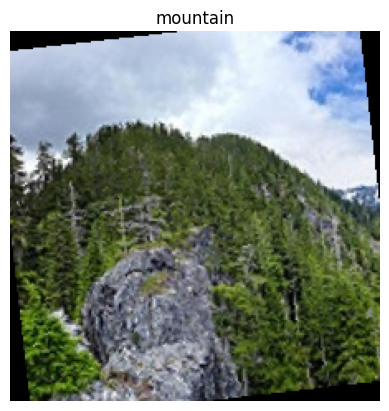

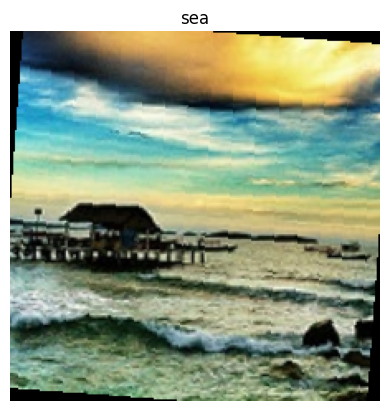

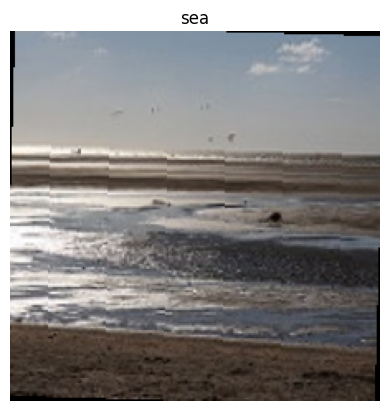

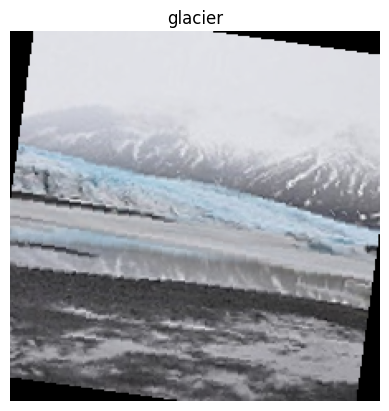

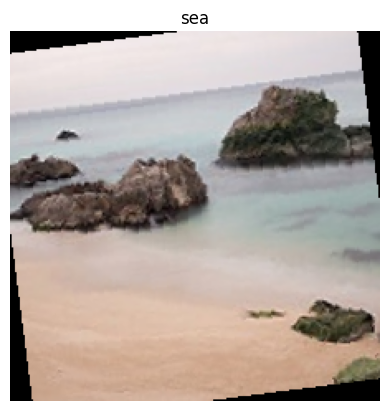

In [79]:
# Simple data exploration: Counting the number of samples per class in each subset.

def count_labels(subset, dataset_full):
    """
    Counts samples per class for a given subset.
    
    Parameters:
        subset: a Subset object of the full dataset.
        dataset_full: the full ImageFolder dataset (to retrieve class names and targets).
        
    Returns:
        A dictionary mapping class names to sample counts.
    """
    counts = {class_name: 0 for class_name in dataset_full.classes}
    for idx in subset.indices:
        label = dataset_full.targets[idx]
        class_name = dataset_full.classes[label]
        counts[class_name] += 1
    return counts

train_counts = count_labels(train_dataset, train_dataset_full)
val_counts = count_labels(val_dataset, train_dataset_full)

# Count labels in test dataset manually (ImageFolder object has `imgs` attribute)
test_counts = {class_name: 0 for class_name in test_dataset.classes}
for _, label in test_dataset.imgs:
    class_name = test_dataset.classes[label]
    test_counts[class_name] += 1

print("Training set samples per class:")
print(train_counts)
print("\nValidation set samples per class:")
print(val_counts)
print("\nTest set samples per class:")
print(test_counts)

# Visualize a few sample images from the training set

def imshow(img, title=None):
    """Display an image after unnormalizing it."""
    img = img.numpy().transpose((1, 2, 0))
    # Unnormalize based on the ImageNet values
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display 5 sample images from the batch
for i in range(5):
    label_name = train_dataset_full.classes[labels[i]]
    imshow(images[i], title=label_name)


## Task 2: ResNet-Based Model
1. Model Setup:

- Use a standard ResNet (e.g., ResNet18, ResNet34) from a deep learning library.
- Replace the final fully-connected layer to output logits for the number of classes in the dataset.

2. Hyperparameters:

- Select a learning rate, batch size, and number of epochs 

- Use cross-entropy loss for multi-class classification.

- Monitor validation loss and accuracy each epoch.

3. Training:

- Train using your chosen optimizer (e.g., Adam, SGD) on the training set.

- Evaluate on the validation set after each epoch to tune hyperparameters or early-stop if desired.

In [80]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 4

# Load pre-trained ResNet18 model and modify the final layer
num_classes = len(train_dataset_full.classes)  # Ensure train_dataset_full is defined from Task 1
model_resnet18 = models.resnet18(weights=True)

# Freeze all feature layers so only the final FC layer is trained
for name, param in model_resnet18.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

in_features = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(in_features, num_classes)  # Replace final layer for our dataset
model_resnet18 = model_resnet18.to(device)

print("Modified ResNet18 Model:")
print(model_resnet18)

Modified ResNet18 Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rel

c:\Users\brian\miniconda3\envs\torch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [81]:
# Define loss and optimizer (only parameters in model.fc will be updated)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.fc.parameters(), lr=learning_rate)

# If using CUDA, set up automatic mixed precision (AMP)
use_amp = device.type == "cuda"

# For mixed precision training (if available)
scaler = torch.amp.GradScaler() if use_amp else None

def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixed precision if scaler is defined
        if scaler:
            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop using the modified training function with mixed precision (if applicable)
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_val_acc = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    train_loss, train_acc = train_one_epoch(model_resnet18, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc = evaluate(model_resnet18, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Time: {elapsed:.2f} sec")
    print(f"  Training   -> Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}%")
    print(f"  Validation -> Loss: {val_loss:.4f} | Accuracy: {val_acc*100:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model_resnet18.state_dict()
        print("  * Best model updated!")


Epoch 1/4 - Time: 34.95 sec
  Training   -> Loss: 0.6275 | Accuracy: 80.01%
  Validation -> Loss: 0.4112 | Accuracy: 85.60%
  * Best model updated!
Epoch 2/4 - Time: 34.78 sec
  Training   -> Loss: 0.3887 | Accuracy: 86.49%
  Validation -> Loss: 0.3381 | Accuracy: 88.51%
  * Best model updated!
Epoch 3/4 - Time: 35.02 sec
  Training   -> Loss: 0.3541 | Accuracy: 87.26%
  Validation -> Loss: 0.3087 | Accuracy: 88.95%
  * Best model updated!
Epoch 4/4 - Time: 34.80 sec
  Training   -> Loss: 0.3466 | Accuracy: 87.60%
  Validation -> Loss: 0.3219 | Accuracy: 88.55%


### Task 3: Custom CNN Model
#### Architecture Design:

- Create a CNN with multiple convolutional layers, batch normalization (if desired), and pooling or stride to reduce spatial dimensions.
- Include fully connected layers at the end to output class probabilities.
- Experiment with kernel sizes (e.g., ) and activation functions (ReLU, etc.).
- Regularization & Hyperparameters:
- Use dropout or weight decay to avoid overfitting (especially if your network is large).
- Train under similar conditions (epochs, batch size, etc.) as the ResNet model for a fair comparison.

#### Training and Validation:

- Train on the same training set; monitor accuracy, loss on validation data.
- Optionally, experiment with learning rate schedules or additional data augmentation.

### Define & instantiate the Custom CNN  
We infer the number of classes from `train_loader`, build our `CustomCNN`, move it to `device`, and set up loss+optimizer.


In [82]:

# Hyperparameters
learning_rate = 0.001
weight_decay   = 1e-4
num_epochs     = 15
dropout_prob   = 0.5

# Infer num_classes from your DataLoader (handles Subset/ImageFolder)
num_classes = len(train_loader.dataset.dataset.classes)

# Custom CNN definition
class CustomCNN(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.avgpool   = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(128, 256), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x).view(x.size(0), -1)
        return self.classifier(x)

# Instantiate model, loss, and optimizer
model_cnn    = CustomCNN(num_classes, dropout_prob).to(device)
criterion    = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

scheduler = ReduceLROnPlateau(
    optimizer_cnn,
    mode="min",
    factor=0.5,
    patience=2,
    verbose=True
)

print(model_cnn)


CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear

c:\Users\brian\miniconda3\envs\torch_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Train & validate the Custom CNN  
This loop handles both training and validation in one cell, printing per‑epoch loss and accuracy.


In [83]:
best_val_acc = 0.0

for epoch in range(num_epochs):
    # ---- Training ----
    model_cnn.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        outputs = model_cnn(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

        train_loss += loss.item() * imgs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total   += labels.size(0)
    
    train_loss /= train_total
    train_acc   = train_correct / train_total

    # ---- Validation ----
    model_cnn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [val]  ", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model_cnn(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total   += labels.size(0)

    val_loss /= val_total
    val_acc   = val_correct / val_total

    # ---- Logging summary ----
    print(f"\nEpoch {epoch+1}/{num_epochs} ─ "
          f"Train Loss: {train_loss:.4f}  Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.4f}  Acc: {val_acc*100:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_cnn_state = model_cnn.state_dict()
        print("  ↑ New best validation accuracy!\n")
    
    scheduler.step(val_loss)
    current_lr = optimizer_cnn.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: LR now {current_lr:.6f}")


Epoch 1/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.23it/s]



Epoch 1/15 ─ Train Loss: 1.1953  Acc: 49.97% | Val Loss: 0.9167  Acc: 63.39%
  ↑ New best validation accuracy!

Epoch 1: LR now 0.001000


Epoch 2/15 [train]: 100%|██████████| 362/362 [00:26<00:00, 13.62it/s]



Epoch 2/15 ─ Train Loss: 0.9960  Acc: 59.88% | Val Loss: 0.8268  Acc: 68.47%
  ↑ New best validation accuracy!

Epoch 2: LR now 0.001000


Epoch 3/15 [train]: 100%|██████████| 362/362 [00:26<00:00, 13.91it/s]



Epoch 3/15 ─ Train Loss: 0.9179  Acc: 63.58% | Val Loss: 0.8899  Acc: 66.53%
Epoch 3: LR now 0.001000


Epoch 4/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.09it/s]



Epoch 4/15 ─ Train Loss: 0.8722  Acc: 65.59% | Val Loss: 0.7869  Acc: 70.97%
  ↑ New best validation accuracy!

Epoch 4: LR now 0.001000


Epoch 5/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.05it/s]



Epoch 5/15 ─ Train Loss: 0.8451  Acc: 66.97% | Val Loss: 0.8030  Acc: 69.15%
Epoch 5: LR now 0.001000


Epoch 6/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 13.93it/s]



Epoch 6/15 ─ Train Loss: 0.8244  Acc: 67.66% | Val Loss: 0.6898  Acc: 73.39%
  ↑ New best validation accuracy!

Epoch 6: LR now 0.001000


Epoch 7/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.10it/s]



Epoch 7/15 ─ Train Loss: 0.7874  Acc: 69.47% | Val Loss: 0.6830  Acc: 74.48%
  ↑ New best validation accuracy!

Epoch 7: LR now 0.001000


Epoch 8/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.31it/s]



Epoch 8/15 ─ Train Loss: 0.7662  Acc: 69.91% | Val Loss: 0.7194  Acc: 72.70%
Epoch 8: LR now 0.001000


Epoch 9/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.26it/s]



Epoch 9/15 ─ Train Loss: 0.7761  Acc: 70.39% | Val Loss: 0.6884  Acc: 75.20%
  ↑ New best validation accuracy!

Epoch 9: LR now 0.001000


Epoch 10/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.30it/s]



Epoch 10/15 ─ Train Loss: 0.7411  Acc: 71.65% | Val Loss: 0.6678  Acc: 75.52%
  ↑ New best validation accuracy!

Epoch 10: LR now 0.001000


Epoch 11/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.35it/s]



Epoch 11/15 ─ Train Loss: 0.7303  Acc: 71.93% | Val Loss: 0.6442  Acc: 76.94%
  ↑ New best validation accuracy!

Epoch 11: LR now 0.001000


Epoch 12/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.33it/s]



Epoch 12/15 ─ Train Loss: 0.7026  Acc: 73.27% | Val Loss: 0.6478  Acc: 75.52%
Epoch 12: LR now 0.001000


Epoch 13/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.34it/s]



Epoch 13/15 ─ Train Loss: 0.6816  Acc: 73.93% | Val Loss: 0.5696  Acc: 80.16%
  ↑ New best validation accuracy!

Epoch 13: LR now 0.001000


Epoch 14/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.31it/s]



Epoch 14/15 ─ Train Loss: 0.6805  Acc: 73.76% | Val Loss: 0.7288  Acc: 72.54%
Epoch 14: LR now 0.001000


Epoch 15/15 [train]: 100%|██████████| 362/362 [00:25<00:00, 14.12it/s]
                                                                    


Epoch 15/15 ─ Train Loss: 0.6725  Acc: 74.61% | Val Loss: 0.6697  Acc: 76.13%
Epoch 15: LR now 0.001000


### 1 · Imports & helper for full‑set evaluation  
We use `sklearn` to turn model outputs into metrics; the helper returns the
ground‑truth and predictions for a given dataloader.


In [84]:


def collect_preds(model, loader, device):
    """Run loader once → lists of y_true and y_pred."""
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs).softmax(1)
            y_pred.extend(outputs.argmax(1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return np.array(y_true), np.array(y_pred)


### 2 · Metric printer & confusion‑matrix plotter  
This cell prints per‑class precision/recall/F1 and shows a colorised confusion
matrix.


In [85]:
# %% [code]
def metrics_and_cm(model, loader, class_names, device, title="Model"):
    y_true, y_pred = collect_preds(model, loader, device)

    # --- classification report ---
    print(f"\n{title} – precision / recall / F1\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    # --- confusion matrix plot ---
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{title} - Confusion Matrix")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], va="center", ha="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black", fontsize=8)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


### 3 · Run metrics for each model  


ResNet18 – precision / recall / F1

              precision    recall  f1-score   support

   buildings      0.853     0.943     0.896       387
      forest      0.992     0.978     0.985       401
     glacier      0.785     0.833     0.808       425
    mountain      0.839     0.764     0.800       444
         sea      0.895     0.933     0.914       402
      street      0.940     0.855     0.896       421

    accuracy                          0.881      2480
   macro avg      0.884     0.884     0.883      2480
weighted avg      0.883     0.881     0.881      2480



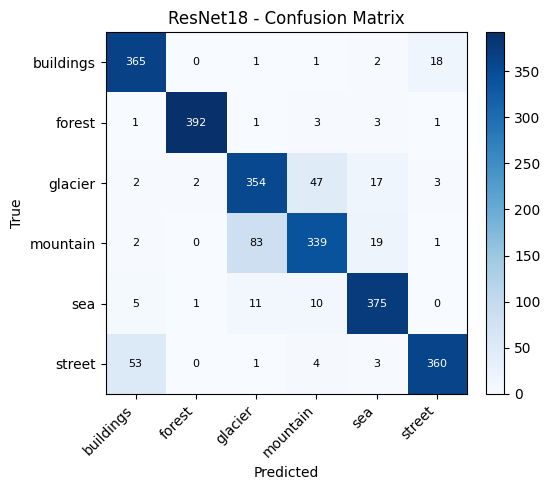


Custom CNN – precision / recall / F1

              precision    recall  f1-score   support

   buildings      0.833     0.592     0.692       387
      forest      0.964     0.925     0.944       401
     glacier      0.760     0.692     0.724       425
    mountain      0.581     0.876     0.699       444
         sea      0.826     0.674     0.742       402
      street      0.739     0.765     0.751       421

    accuracy                          0.756      2480
   macro avg      0.784     0.754     0.759      2480
weighted avg      0.779     0.756     0.758      2480



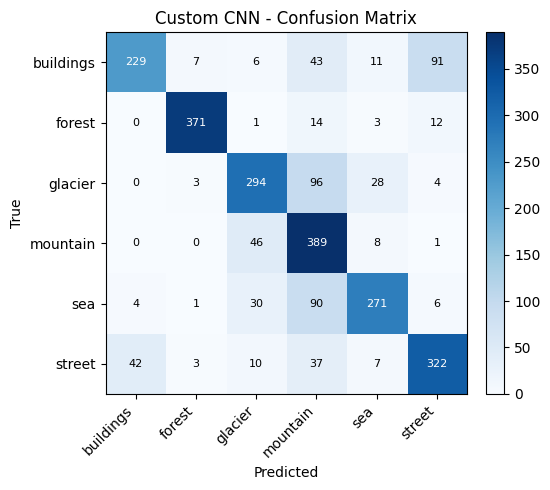

In [86]:
class_names = train_loader.dataset.dataset.classes  # list of labels

# ResNet:
metrics_and_cm(model_resnet18, val_loader, class_names, device, title="ResNet18")

# Custom CNN:
metrics_and_cm(model_cnn,      val_loader, class_names, device, title="Custom CNN")
